# 4. Permutation Test Results

Organizes permutation results
1. Average lassopcr searchlight results over cv iterations
2. Calculate the permutation distribution
3. Run permutation tests: compare lassopcr-sl results against the permutation distribution
4. Save the mask for the significant voxels.
5. Calculate the breakdown by situation

*Yiyu Wang 2022/01*


In [2]:
import glob
import os
import numpy as np
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt

# stats
from scipy import linalg, ndimage, stats
from scipy.stats import norm

# nifti handling
from nilearn.input_data import NiftiMasker
import nilearn.masking as masking
from nilearn.masking import apply_mask

from nilearn import image
from nilearn.image import new_img_like, load_img, get_data, concat_imgs, mean_img, math_img, index_img,threshold_img
from nilearn.reporting import get_clusters_table
from nilearn.glm import threshold_stats_img

# plotting modules
from nilearn import plotting
from nilearn.plotting import plot_stat_map, plot_img, show

# nilearn mask:
from nilearn.datasets import load_mni152_gm_mask

import warnings
warnings.filterwarnings('ignore')

/Users/yiyuwang/anaconda3/lib/python3.7/site-packages/nilearn/__init__.py:67: FutureWarning: Python 3.7 support is deprecated and will be removed in release 0.12 of Nilearn. Consider switching to Python 3.9 or 3.10.
  _python_deprecation_warnings()
/Users/yiyuwang/anaconda3/lib/python3.7/site-packages/nilearn/input_data/__init__.py:23: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


In [3]:
bg_img = 'masks/FSL_MNI152_T1_3mm_brain.nii.gz'

#load behavioral data
behavdata_dir =  'BehavData/'
zratings =glob.glob(behavdata_dir +'AffVids_novel_interpolated_rating_zscored.csv')
zratings = pd.read_csv(zratings[0],index_col=0).reset_index()

my_radius = 15

# subjects information
subjects_str = ['04','05','06','07','08','09','10','11','12','13','14','15','16','17','18','19','23','25','26','28','29'] 
subjects = list(range(4,20))+[23,25,26,28,29]
Nsub = len(subjects)
print("subjects in this analysis:")
print(subjects_str)
print(f"**** n = {Nsub} *****" )

k_fold = 3
my_radius = 15
cluster_thre = 1
my_slices = [-24, -12, 0, 12, 21, 30, 42, 54]


VMAX = 0.45

res_dir = 'results/searchlight_lassopcr/'
avg_dir = 'results/searchlight_wholebrain/'
permutation_dir = 'results/permutation/'
permutation_test_res_dir = 'results/permutation_test/'

if not os.path.isdir(permutation_test_res_dir):
    os.mkdir(permutation_test_res_dir)
if not os.path.isdir(avg_dir):
    os.mkdir(avg_dir)
        
        

subjects in this analysis:
['04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '23', '25', '26', '28', '29']
**** n = 21 *****


(60, 72, 60)


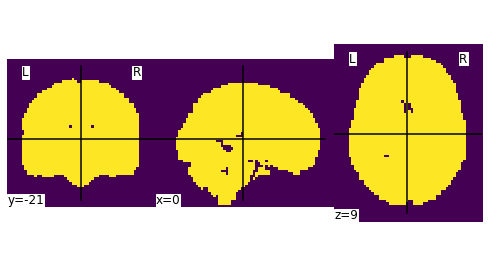

In [4]:
mask_path ='masks/FSL_binary_MNI152_T1_3mm_brain.nii.gz'
mask = nib.load(mask_path)
plot_img(mask)
print(mask.shape)

In [5]:
def compare_against_permutation(permutation_img, lassopcr_img, mask, n_perm, prob_thr = 0.05, cluster_thre=15):  
    # load mask for all the functional voxels
    masker = NiftiMasker(mask_img=mask, mask_strategy='epi',standardize=False)
    
    # extract data from mask
    masked_permutation_scores = masker.fit_transform(permutation_img)
    masked_lassopcr_scores = masker.fit_transform(lassopcr_img)
    
    # pval map
    n_func_voxel = np.shape(masked_permutation_scores)[1]
    masked_significance = np.zeros(n_func_voxel)
    
    pvals_map = np.zeros(n_func_voxel)
    prob_thr = prob_thr
    for i in range(n_func_voxel):
        prob = np.sum(masked_permutation_scores[:,i] >= masked_lassopcr_scores[:,i])/n_perm
        pvals_map[i] = prob
        if prob < prob_thr:
            masked_significance[i] = 1
            

    # extract r-values for significant voxels:
    masked_significant_scores = np.zeros(n_func_voxel)
    masked_significant_scores[np.where(masked_significance==1)] = masked_lassopcr_scores[0][np.where(masked_significance==1)]
    significance_map_img = masker.inverse_transform(masked_significant_scores)

    significance_map_cluster_thr = threshold_stats_img(significance_map_img, mask_img= mask, threshold= 0,cluster_threshold=cluster_thre, height_control=None)
    unc_significance_map_img = new_img_like(mask, get_data(significance_map_cluster_thr[0]), affine=mask.affine)
    
    # fwe p correction
    fwe_threshold = family_wise_error_permutation(permutation_img, mask, prob_thr=prob_thr)
    
    
    if len(np.shape(lassopcr_img))==4: #if has a forth dimension, the forth dimension should be 1
        if np.shape(lassopcr_img)[3] !=1 :
            raise Exception("Check lassopcr image 4th dimension!!")
        else:
            fwe_corr_significance_map_img = threshold_img(index_img(lassopcr_img,0), threshold = fwe_threshold, two_sided=False, copy=False)
            
    
    elif len(np.shape(lassopcr_img))==3:
        fwe_corr_significance_map_img = threshold_img(lassopcr_img, threshold = fwe_threshold, two_sided=False, copy=False)
        
    else:
        raise Exception('ERROR in lassopcr_img dimension!')
    
    
    return unc_significance_map_img, fwe_threshold, fwe_corr_significance_map_img


In [6]:
def family_wise_error_permutation(permutation_img, mask,prob_thr):
    
    masker = NiftiMasker(mask_img=mask, mask_strategy='epi',standardize=False)
    masked_permutation_scores = masker.fit_transform(permutation_img)
    fwe = np.percentile(masked_permutation_scores, (1-prob_thr)*100)
    
    return fwe

def fdr_permutation(pvals_map, masked_lassopcr_scores, prob_thr=0.05): 
    masked_lassopcr_scores_sorted = np.sort(masked_lassopcr_scores, axis=None)
    n_samples = np.shape(masked_lassopcr_scores)[1]
    pos = pvals_map < prob_thr * np.linspace(
        .5 / n_samples, 1 - .5 / n_samples, n_samples)
    if pos.any():
        fdr =  np.ravel(masked_lassopcr_scores_sorted)[pos][-1] - 1.e-12
    else:
        fdr = 1
    
    return fdr

In [7]:
def get_lasso(train_cat, test_cat, score_name):
    lasso_file_path = avg_dir + f'kfold3_searchlight_{score_name}_train_{train_cat}_test_{test_cat}_avg.nii.gz'
    lassopcr_img = nib.load(lasso_file_path)

    return lassopcr_img

def get_permutation(train_cat, test_cat, score_name):
    permutation_img = nib.load(permutation_test_res_dir + f'train_{train_cat}_test_{test_cat}_permutation_distribution_{score_name}.nii.gz')
    n_perm = permutation_img.shape[3]
    print("number of permutations: ", n_perm)
    
    return permutation_img, n_perm
    

In [8]:
# whether calculate the average of cv:
average_cv = False
# whether run permutation:
calculate = True

# Across Situation Model:

In [8]:
# calculate the average 

if average_cv:
    train_cat_list = ['Situation_General']
    test_cat_list = ['Heights','Social','Spiders']


    # calculate average images
    score_list = ['rmse','pearsonr']
    for score_name in score_list:
        for train_cat in train_cat_list:
            for test_cat in test_cat_list:

                file_list = glob.glob(res_dir + f'cv*_kfold3_searchlight_{score_name}_train_{train_cat}_test_{test_cat}*.nii.gz')
                cv_avg_img = mean_img(file_list)
                
                nib.save(cv_avg_img, avg_dir + f'kfold3_searchlight_{score_name}_train_{train_cat}_test_{test_cat}_avg.nii.gz')

                # a quick visual check for the saved files
                plotting.plot_stat_map(cv_avg_img, display_mode='z', cut_coords=my_slices,threshold=0.0,bg_img=bg_img,
                                                title= f'cv average image: SG-{test_cat}', colorbar=True)



pearsonr
train:  Situation_General
test:  Heights
number of permutations:  1192
family wise correction threshold:  0.17532557859775813
train:  Situation_General
test:  Social
number of permutations:  1201
family wise correction threshold:  0.17572701041249456
train:  Situation_General
test:  Spiders
number of permutations:  1201
family wise correction threshold:  0.17648713639340952


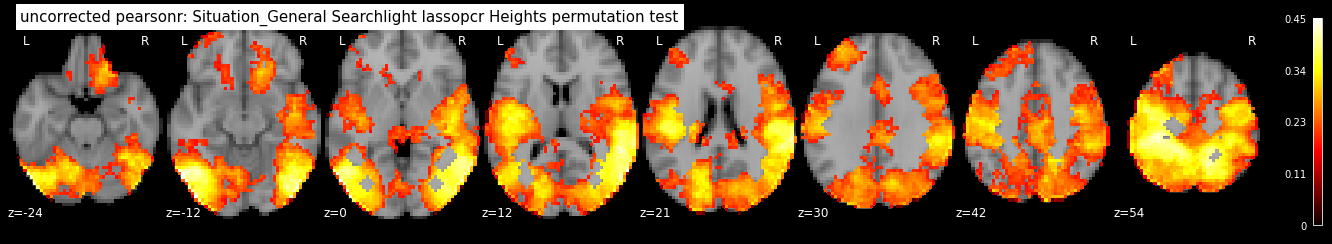

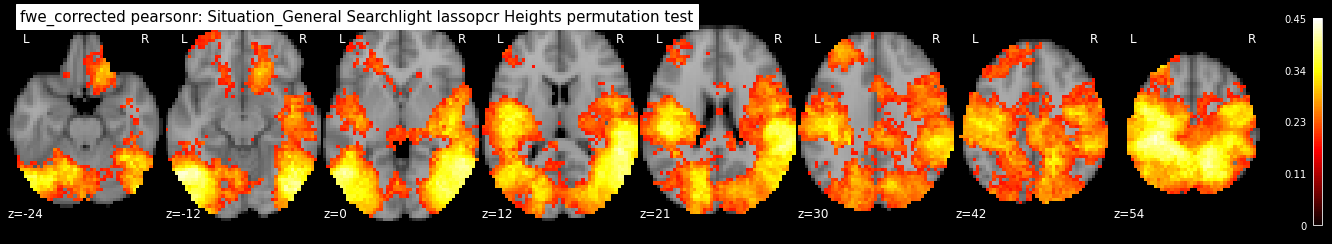

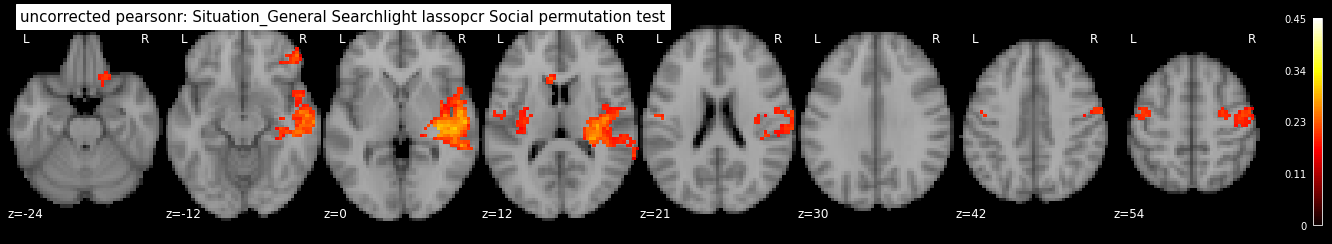

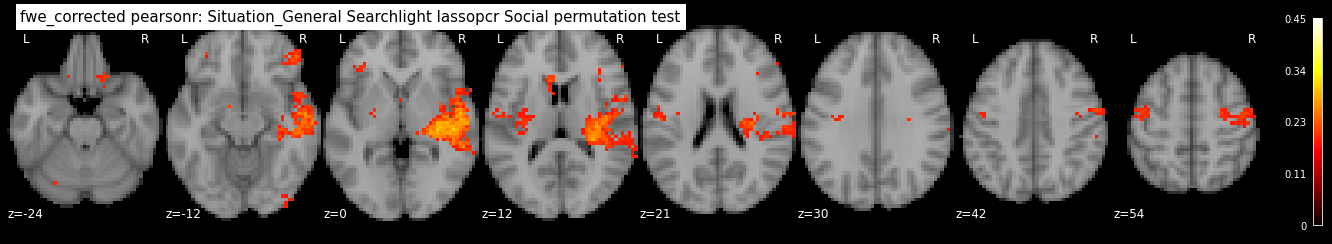

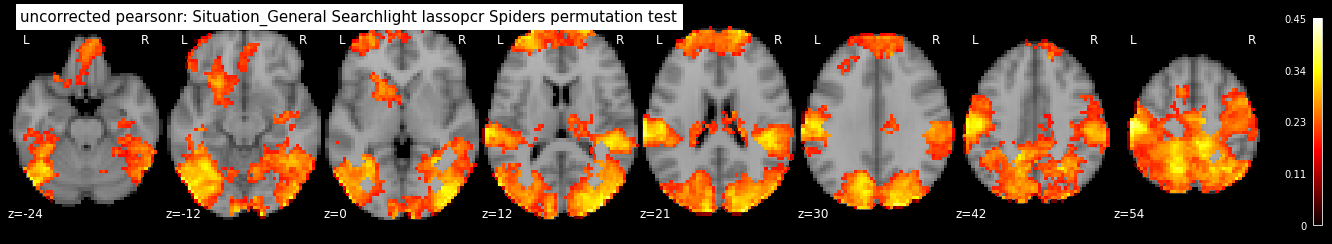

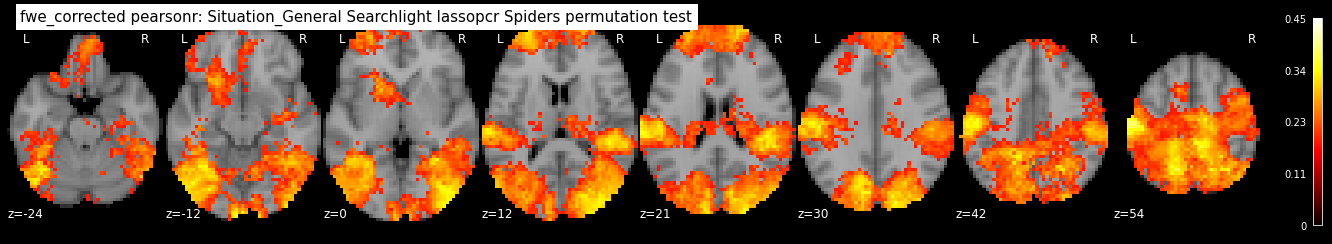

In [9]:
# permutation test
train_cat_list = ['Situation_General']
test_cat_list = ['Heights','Social','Spiders']

score_list = ['pearsonr']


prob_thr = 0.05

for score_name in score_list:
    print(score_name)
    for train_cat in train_cat_list:
        for test_cat in test_cat_list:
            print("train: ", train_cat)
            print("test: ", test_cat)
            
            lassopcr_img = get_lasso(train_cat, test_cat, score_name)

            # load permutation distributions:
            permutation_img, n_perm = get_permutation(train_cat, test_cat, score_name)   
            
            # run permutation test:
            unc_significance_map_img, fwe_threshold, fwe_corr_significance_map_img = compare_against_permutation(permutation_img,lassopcr_img,mask,n_perm, prob_thr=prob_thr)
            print("family wise correction threshold: ", fwe_threshold)
            
            nib.save(fwe_corr_significance_map_img, permutation_test_res_dir + f'train_{train_cat}_test_{test_cat}_significant_{score_name}_fwe.nii.gz')
            
            # quick visual check to make sure the image is not empty
            plotting.plot_stat_map(unc_significance_map_img, display_mode='z', cut_coords=my_slices,threshold=0.0,bg_img=bg_img, title= f'uncorrected {score_name}: {train_cat} Searchlight lassopcr {test_cat} permutation test', colorbar=True, vmax = VMAX)
            plotting.plot_stat_map(fwe_corr_significance_map_img, display_mode='z', cut_coords=my_slices,threshold=0.0,bg_img=bg_img, title= f'fwe_corrected {score_name}: {train_cat} Searchlight lassopcr {test_cat} permutation test', colorbar=True, vmax = VMAX)
            
            
            
            

In [ ]:
permutation_test_res_dir = 'results/permutation_test/'


# conjunction analysis: overlap areas between SGH + SGSO + SGSP
SG_H = nib.load(permutation_test_res_dir + f'train_Situation_General_test_Heights_significant_pearsonr_fwe.nii.gz')
SG_SO = nib.load(permutation_test_res_dir + f'train_Situation_General_test_Social_significant_pearsonr_fwe.nii.gz')
SG_SP = nib.load(permutation_test_res_dir + f'train_Situation_General_test_Spiders_significant_pearsonr_fwe.nii.gz')


SG_H_mask = math_img('img != 0', img = SG_H)
SG_SO_mask = math_img('img != 0', img = SG_SO)
SG_SP_mask = math_img('img != 0', img = SG_SP)

overlay = math_img('img1 + img2 + img3', img1=SG_H_mask, img2=SG_SO_mask, img3=SG_SP_mask)
nib.save(overlay, permutation_test_res_dir + 'AS_overlay_byNum.nii.gz')


SGSO_only =  math_img('img * 2', img = SG_SO_mask)
SGSP_only =  math_img('img * 4', img = SG_SP_mask)

overlay_by_sit = math_img('img1 + img2 + img3', img1=SG_H_mask, img2=SGSO_only, img3=SGSP_only)

# swtich value 3 and 4 for better visualization:
overlay_by_sit_data = overlay_by_sit.get_fdata()
three_idx = np.where(overlay_by_sit_data ==3)
four_idx = np.where(overlay_by_sit_data ==4)
overlay_by_sit_data[four_idx] = 3
overlay_by_sit_data[three_idx] = 4
overlay_by_sit = new_img_like(overlay_by_sit, overlay_by_sit_data)
nib.save(overlay_by_sit, permutation_test_res_dir + 'AS_overlay_bySit.nii.gz')



## Situation by Situation Model: 

In [10]:
# calculate the average 

if average_cv:
    train_cat_list = ['Heights','Social','Spiders']

    # calculate average images
    score_list = ['rmse','pearsonr']
    for score_name in score_list:
        for train_cat in train_cat_list:
            test_cat = train_cat

            file_list = glob.glob(res_dir + f'cv*_kfold3_searchlight_{score_name}_train_{train_cat}_test_{test_cat}*.nii.gz')
            cv_avg_img = mean_img(file_list)
            
            nib.save(cv_avg_img,avg_dir + f'kfold3_searchlight_{score_name}_train_{train_cat}_test_{test_cat}_avg.nii.gz')

            # a quick visual check for the saved files
            plotting.plot_stat_map(cv_avg_img, display_mode='z', cut_coords=my_slices,threshold=0.0,bg_img=bg_img,
                                            title= f'cv average image: SS-{test_cat}', colorbar=True)



pearsonr
train:  Heights
test:  Heights
number of permutations:  1201
family wise correction threshold:  0.17323854042067865
train:  Social
test:  Social
number of permutations:  1199
family wise correction threshold:  0.17358821704624883
train:  Spiders
test:  Spiders
number of permutations:  1198
family wise correction threshold:  0.1753727745181206


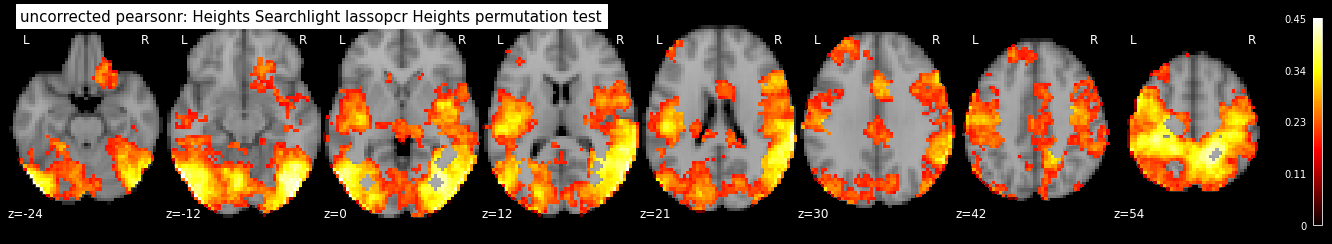

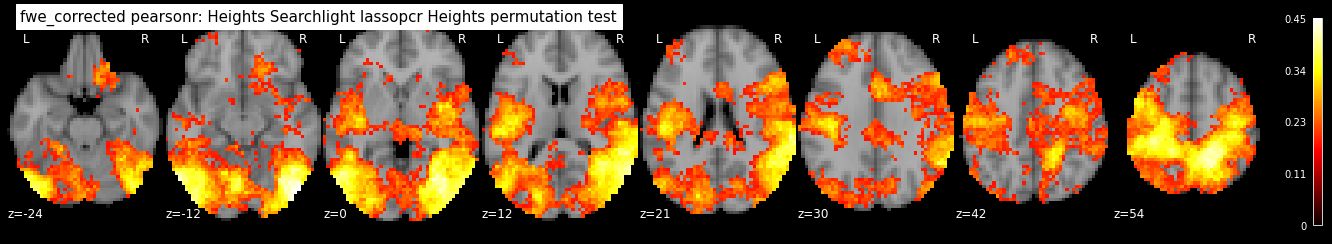

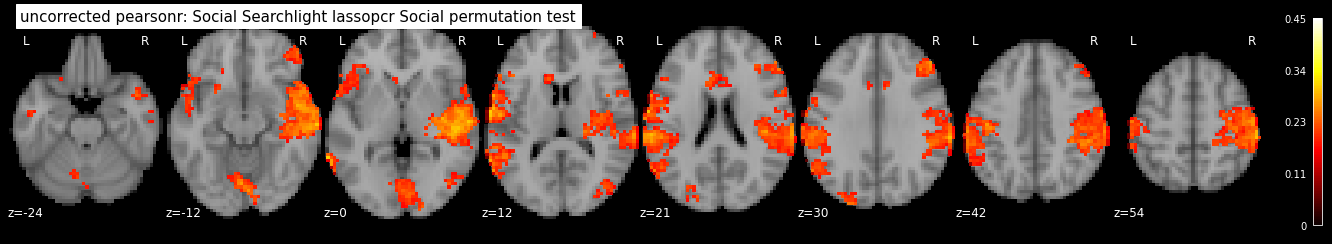

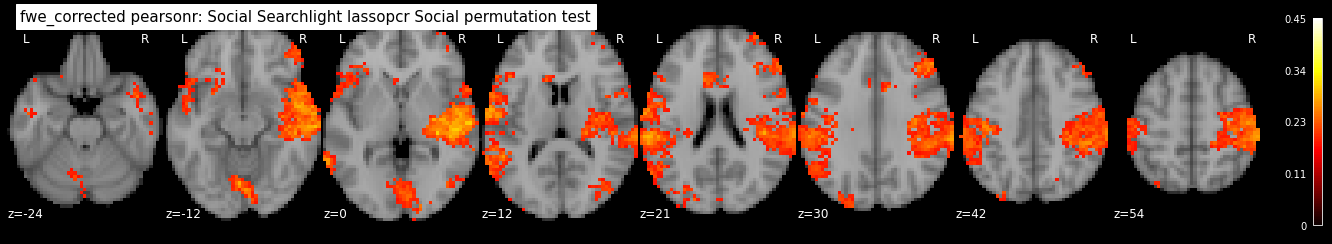

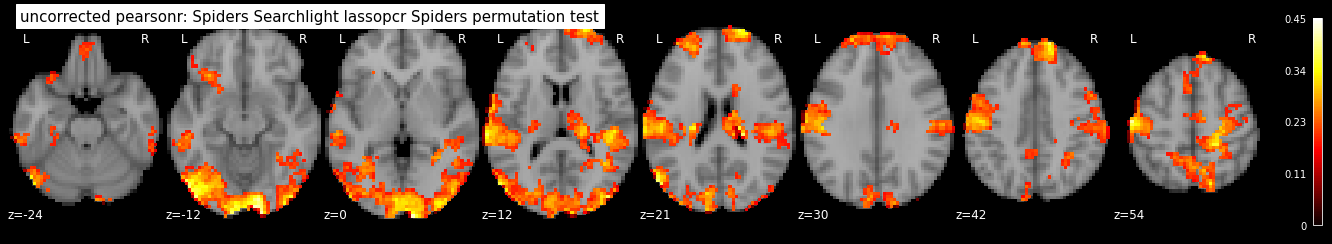

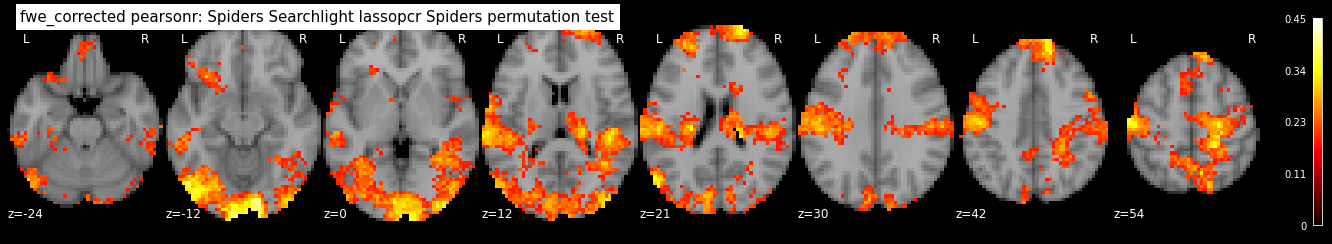

In [11]:
# run permutation:
train_cat_list = ['Heights','Social','Spiders']


score_list = ['pearsonr']
    
prob_thr = 0.05

for score_name in score_list:
    print(score_name)
    for train_cat in train_cat_list:
        test_cat = train_cat
        print("train: ", train_cat)
        print("test: ", test_cat)


        lassopcr_img = get_lasso(train_cat, test_cat, score_name)

        # load permutation distributions:
        permutation_img, n_perm = get_permutation(train_cat, test_cat, score_name)   

        # run permutation test:
        unc_significance_map_img, fwe_threshold, fwe_corr_significance_map_img = compare_against_permutation(permutation_img,lassopcr_img,mask,n_perm, prob_thr=prob_thr)
        print("family wise correction threshold: ", fwe_threshold)


        nib.save(fwe_corr_significance_map_img, permutation_test_res_dir + f'train_{train_cat}_test_{test_cat}_significant_{score_name}_fwe.nii.gz')

        # quick visual check to make sure the image is not empty
        plotting.plot_stat_map(unc_significance_map_img, display_mode='z', cut_coords=my_slices,threshold=0.0,bg_img=bg_img, title= f'uncorrected {score_name}: {train_cat} Searchlight lassopcr {test_cat} permutation test', colorbar=True, vmax = VMAX)
        plotting.plot_stat_map(fwe_corr_significance_map_img, display_mode='z', cut_coords=my_slices,threshold=0.0,bg_img=bg_img, title= f'fwe_corrected {score_name}: {train_cat} Searchlight lassopcr {test_cat} permutation test', colorbar=True, vmax = VMAX)



            

In [9]:
# overlay by situation-by-situation model:


# conduction conjunction analysis: calculate overlapping areas between HH, SOSO, SPSP
HH = nib.load(permutation_test_res_dir + f'train_Heights_test_Heights_significant_pearsonr_fwe.nii.gz')
SOSO = nib.load(permutation_test_res_dir + f'train_Social_test_Social_significant_pearsonr_fwe.nii.gz')
SPSP = nib.load(permutation_test_res_dir + f'train_Spiders_test_Spiders_significant_pearsonr_fwe.nii.gz')

HH_mask = math_img('img != 0', img = HH)
SOSO_mask = math_img('img != 0', img = SOSO)
SPSP_mask = math_img('img != 0', img = SPSP)

overlay = math_img('img1 + img2 + img3', img1=HH_mask, img2=SOSO_mask, img3=SPSP_mask)
nib.save(overlay, permutation_test_res_dir + 'SS_overlay_byNum.nii.gz')


SO_only =  math_img('img * 2', img = SOSO_mask)
SP_only =  math_img('img * 4', img = SPSP_mask)

overlay_by_sit = math_img('img1 + img2 + img3', img1=HH_mask, img2=SO_only, img3=SP_only)
# swtich value 3 and 4 for better visualization:
overlay_by_sit_data = overlay_by_sit.get_fdata()
three_idx = np.where(overlay_by_sit_data ==3)
four_idx = np.where(overlay_by_sit_data ==4)
overlay_by_sit_data[four_idx] = 3
overlay_by_sit_data[three_idx] = 4
overlay_by_sit = new_img_like(overlay_by_sit, overlay_by_sit_data)
nib.save(overlay_by_sit, permutation_test_res_dir + 'SS_overlay_bySit.nii.gz')

